In [4]:
import math
import  numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def f(x):
    return 3*x**2 - 4*x + 5


In [6]:
f(3.0)

20.0

In [7]:
xs = np.arange(-5, 5, 0.25)

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

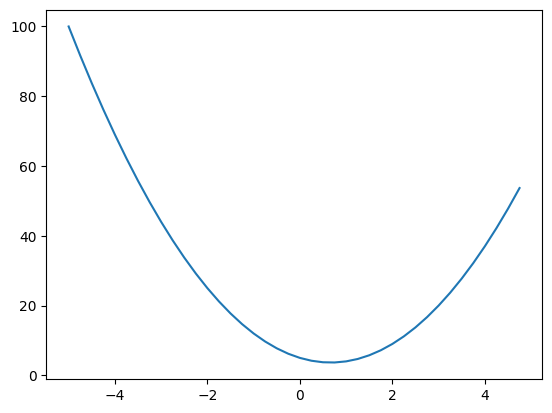

In [10]:
ys = f(xs)
ys
plt.plot(xs, ys)

In [18]:
h = 0.000001
x = 1
(f(x + h) - f(x)) / h

2.0000030005462577

In [19]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [20]:
h = 0.000001

# inputs
a = 2.0
b = -3.0
c = 10.0
d = a*b + c

d1 = a*b + c
a += h
d2 = a*b + c

print("d1: ", d1)
print("d2: ", d2)
print("slop: ", (d2 - d1) / h)


d1:  4.0
d2:  3.9999969999999996
slop:  -3.000000000419334


In [188]:
class Value:

    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data:.4f})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1. * out.grad
            other.grad = 1. * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * (other**-1)

    def __sub__(self, other):
        return self + (-other)

    def __neg__(self):
        return self * -1

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self, other), '**')
        def _backward():
            self.grad += other * (out.data ** (other - 1)) * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1. - (t ** 2)) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'

f = Value(-2., label='f')

L = d * f; L.label = 'L'
print(d)

Value(data=4.0000)


In [189]:
a = Value(2.0, label='a')
b = Value(4.0, label='b')
a-b

Value(data=-2.0000)

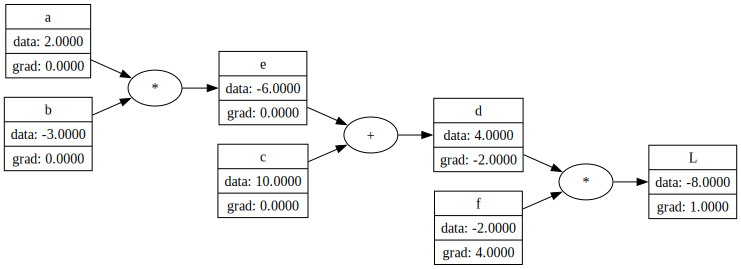

In [78]:
from graphviz import Digraph

def trace(root):
    nodes,edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label=f"{n.label}| data: {n.data:.4f}| grad: {n.grad:.4f}", shape='record')
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot
draw_dot(L)

L = d * f

dL/dd =? f

->> (f(x+h) - f(x)) / h
=> ((d+h)*f - d*f) / h
<=>  (d*f + h*f - d*f) / h
<=> d*f / h
<=> f

dL / dc

c -> d

dd / dc = 1.0

d = c + e

(c + e + h) - (c + e) / h

1 => dd / de = 1.0


In [77]:
L.grad = 1
d.grad = f.data
f.grad = d.data

In [80]:
def lol():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2., label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'; d.data += h
    f = Value(-2., label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h)

lol()

-2.000000000000668


In [97]:


print(L.data)


-8.0


In [101]:
epoch = 10000
h = 0.001


# Initialize
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
f = Value(-2., label='f')

for i in range(epoch):

    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    L = d * f; L.label = 'L'

    if i % 10 == 0:
        print(f"Epoch {i}: loss L: {L.data:.4f}")

    # Backward
    L.grad = 1.0

    # L = d * f
    d.grad = f.data
    f.grad = d.data

    # d = e + c
    e.grad  = d.grad * 1.0
    c.grad = d.grad * 1.0

    # e = a * b
    a.grad = e.grad * b.data
    b.grad = e.data * c.data

    # Update data
    a.data = a.data - (h * a.grad)
    b.data = b.data - (h * b.grad)
    c.data = c.data - (h * c.grad)
    f.data = f.data - (h * f.grad)


# In kết quả cuối cùng
print(f"Final Loss L = {L.data:.8f}")
print(f"a={a.data:.4f}, b={b.data:.4f}, c={c.data:.4f}, f={f.data:.4f}")


Epoch 0: loss L: -8.0000
Epoch 10: loss L: -10.7243
Epoch 20: loss L: -13.0427
Epoch 30: loss L: -15.0842
Epoch 40: loss L: -16.9308
Epoch 50: loss L: -18.6368
Epoch 60: loss L: -20.2389
Epoch 70: loss L: -21.7630
Epoch 80: loss L: -23.2278
Epoch 90: loss L: -24.6472
Epoch 100: loss L: -26.0317
Epoch 110: loss L: -27.3897
Epoch 120: loss L: -28.7276
Epoch 130: loss L: -30.0508
Epoch 140: loss L: -31.3636
Epoch 150: loss L: -32.6698
Epoch 160: loss L: -33.9726
Epoch 170: loss L: -35.2746
Epoch 180: loss L: -36.5783
Epoch 190: loss L: -37.8858
Epoch 200: loss L: -39.1990
Epoch 210: loss L: -40.5196
Epoch 220: loss L: -41.8492
Epoch 230: loss L: -43.1892
Epoch 240: loss L: -44.5409
Epoch 250: loss L: -45.9056
Epoch 260: loss L: -47.2843
Epoch 270: loss L: -48.6783
Epoch 280: loss L: -50.0885
Epoch 290: loss L: -51.5158
Epoch 300: loss L: -52.9613
Epoch 310: loss L: -54.4257
Epoch 320: loss L: -55.9101
Epoch 330: loss L: -57.4151
Epoch 340: loss L: -58.9417
Epoch 350: loss L: -60.4905
Epoc

In [102]:
# Giả sử lớp Value() đã được định nghĩa
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
f = Value(-2., label='f')

epoch = 100
h = 0.01 # Tăng learning rate lên một chút

for i in range(epoch):

    # -------- BƯỚC 1: FORWARD PASS (TÍNH TOÁN LẠI TỪ ĐẦU) --------
    # Chúng ta phải tính toán LẠI MỌI THỨ từ các tham số a, b, c, f
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    L = d * f; L.label = 'L'

    if i % 10 == 0:
        print(f"Epoch {i}: Loss L = {L.data:.8f}")

    # -------- BƯỚC 2: BACKWARD PASS (TÍNH GRADIENT) --------
    L.grad = 1.0

    # L = d * f
    d.grad = f.data
    f.grad = d.data

    # d = e + c
    e.grad = d.grad * 1.0
    c.grad = d.grad * 1.0

    # e = a * b
    a.grad = e.grad * b.data
    b.grad = e.grad * a.data # <-- LỖI CỦA BẠN ĐÃ ĐƯỢC SỬA (trước là f.data * c.data)

    # -------- BƯỚC 3: UPDATE STEP (CẬP NHẬT CHỈ THAM SỐ) --------
    # Dùng dấu TRỪ (-) để thực hiện Gradient DESCENT (đi xuống)
    a.data = a.data - (h * a.grad)
    b.data = b.data - (h * b.grad)
    c.data = c.data - (h * c.grad)
    f.data = f.data - (h * f.grad)


# In kết quả cuối cùng
print(f"Final Loss L = {L.data:.8f}")
print(f"a={a.data:.4f}, b={b.data:.4f}, c={c.data:.4f}, f={f.data:.4f}")

Epoch 0: Loss L = -8.00000000
Epoch 10: Loss L = -16.66837247
Epoch 20: Loss L = -29.40699637
Epoch 30: Loss L = -48.13134747
Epoch 40: Loss L = -80.77801918
Epoch 50: Loss L = -176.30869596
Epoch 60: Loss L = -880.21399564
Epoch 70: Loss L = -91191.13314419
Epoch 80: Loss L = -398806710873716976789779158097705527401069298519381301541079716852553938185698014410852710076957724229154476320324387713028420549521849283984691119769215106563593858942490378240.00000000
Epoch 90: Loss L = -inf
Final Loss L = -inf
a=-inf, b=-inf, c=inf, f=-inf


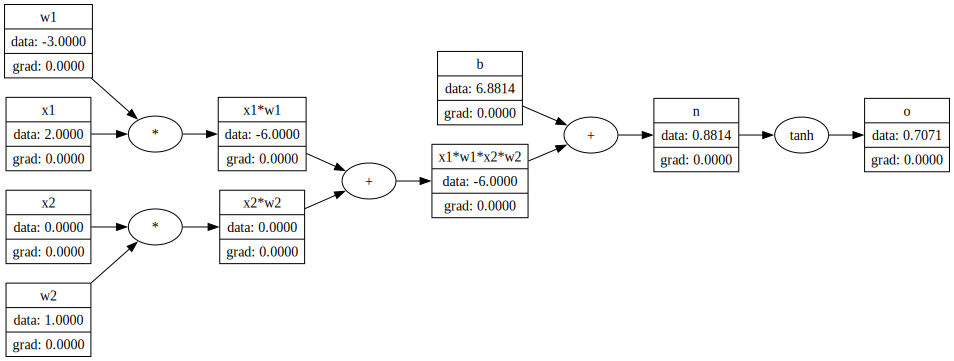

In [169]:
# Input x1 x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weight w1 w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + w2*w2 + b
x1w1 = w1*x1; x1w1.label = 'x1*w1'
x2w2 = w2*x2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1*x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'
draw_dot(o)


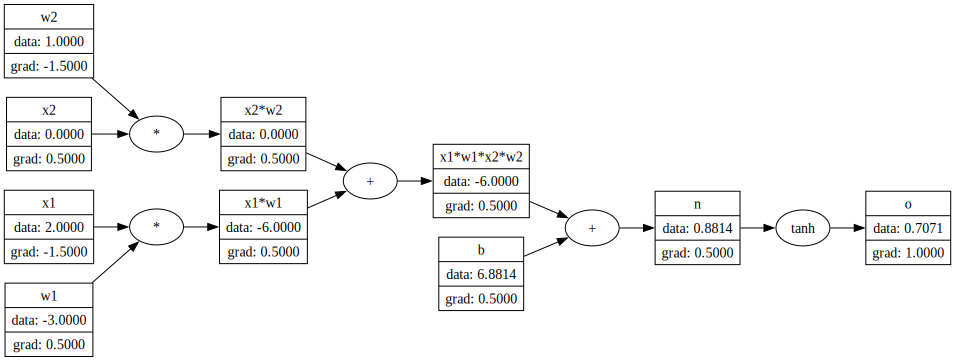

In [157]:
o.grad = 1.

# o = tanh(n)
# d0 / dn = 1 - tanh(n) ** 2 <=> 1 - o**2
n.grad = (1 - (o.data ** 2)) * o.grad

# n = x1w1x2w2 + b
x1w1x2w2.grad = n.grad
b.grad = n.grad

# x1w1x2w2 = x1w1 + x2w2
x1w1.grad = x1w1x2w2.grad
x2w2.grad =  x1w1x2w2.grad

# x1w1 =  x1 * w1
x1.grad = w1.data * x1w1.grad
w1.grad = w2.data * x1w1.grad

# x2w2 = x2 * w2
x2.grad = w2.data * x2w2.grad
w2.grad = w1.data * x2w2.grad

draw_dot(o)


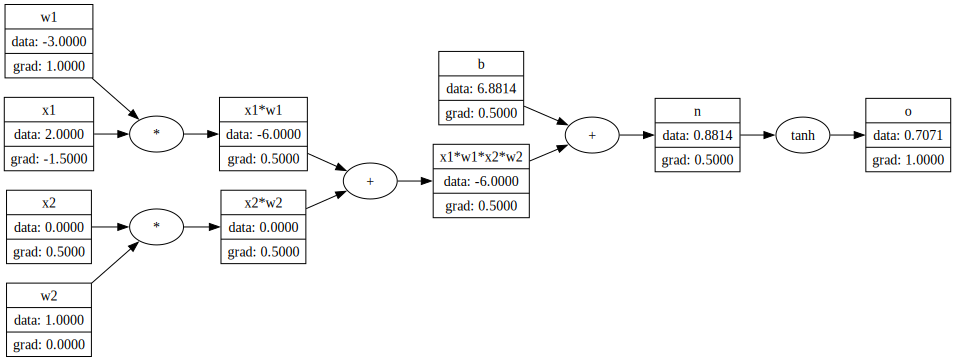

In [170]:
o.grad = 1.
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

draw_dot(o)

In [173]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
topo


[Value(data=6.8814),
 Value(data=0.0000),
 Value(data=1.0000),
 Value(data=0.0000),
 Value(data=2.0000),
 Value(data=-3.0000),
 Value(data=-6.0000),
 Value(data=-6.0000),
 Value(data=0.8814),
 Value(data=0.7071)]

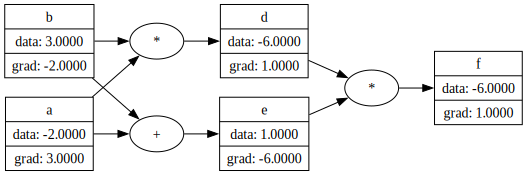

In [178]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b ; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()
draw_dot(f)

In [193]:
import torch
x1 = torch.tensor([-3.0]).double() ; x1.requires_grad = True
x2 = torch.tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.tensor([-3.]).double(); w1.requires_grad = True
w2 = torch.tensor([1.]).double(); w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double(); b.requires_grad = True

n = (x1*w1 + x2*w2) + b
o = torch.tanh(n)


print(o.data.item())
o.backward()

print(x1.grad.item())
print(x2.grad.item())
print(w1.grad.item())
print(w2.grad.item())


0.9999999999999679
-1.9251267246999904e-13
6.417089082333301e-14
-1.9251267246999904e-13
0.0
